In [1]:
import matplotlib.pyplot as plt # For ploting field
import numpy as np
import json

import larp # Our tool [pip install Larp]
import larp.io as lpio

# ---- Required Data ------
requests_file_path = "docs/demos/Routes for Austin TX/example_requests.json" # JSON with origins ('point1') and destinations ('point2') with bounding box of service area
map_geojson_file_path = "path/to/austin_downtown.geojson" # Download from OpenStreetMap

from_crs_requests = "WGS84"
from_crs_map = "urn:ogc:def:crs:OGC:1.3:CRS84"
to_crs = "EPSG:3857"

def progress_bar(percentage, size=100, end=False):
    # https://gist.github.com/wzjoriv/4906a6722805f2d1194a40ddfd158642
    count = int(percentage*size)
    percentage_int = int(percentage*100)
    print(f"({percentage_int:3d}%)[{'|'*count+' '*(size-count)}]", end="\n" if percentage == 1.0 or end else "\r")

In [2]:
# load origin and destinations
with open(requests_file_path) as file:
    requestsF = json.load(file)

# Project coordinates to meters
## Project bounding box
requestsF['boundingbox'] = larp.project_points(requestsF['boundingbox'], from_crs=from_crs_requests, to_crs=to_crs)

## Project origin and destination of routes
locations = []
for i in range(len(requestsF['routes'])):
    for j in range(len(requestsF['routes'][i])):
        locations.append(requestsF['routes'][i][j]['point1'])
        locations.append(requestsF['routes'][i][j]['point2'])

locations = larp.project_points(locations, from_crs=from_crs_requests, to_crs=to_crs)
starts = locations[::2]
ends = locations[1::2]


edges = [0.01, 0.2, 0.4, 0.6, 0.8]

In [3]:
# Load potential field for Austin
field = lpio.loadGeoJSONFile(map_geojson_file_path)
lpio.projectCoordinates(field, from_crs=from_crs_map, to_crs=to_crs)
field.set_all_repulsion([[100.0, 0.0], [0.0, 100.0]]) # strength of repulsion from building (higher = consider greater push away from buildings)

# Readjust window for bounding box
field.reload_center_point(False)
field.center_point = np.mean(requestsF['boundingbox'], axis=0)
field.size = np.array([np.max(np.abs(requestsF['boundingbox'] - field.center_point))*2]*2)

# Remove rgjs far from window bounds (squared distance)
mask = field.squared_dist_list([field.center_point], scaled=False)[0] < field.size[0]**2/2.0
not_in_circle = np.where(~mask)
field.delRGJ(not_in_circle)

print(f"Objects remaining:")
progress_bar(float(sum(mask))/len(mask), end=True)


Objects remaining:
( 29%)[|||||||||||||||||||||||||||||                                                                       ]


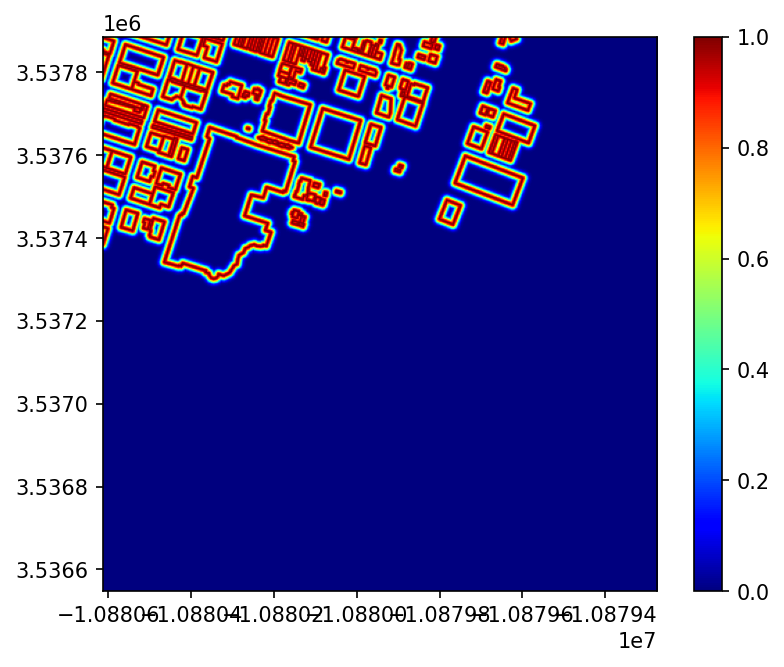

In [4]:
display = field.to_image(resolution=400, margin=0)

plt.figure(dpi=150)
plt.imshow(display, cmap='jet', extent=field.get_extent())
plt.colorbar()
plt.clim(0.0,1.0)
plt.show()

In [5]:
# Decompose field and build routing network
## Lower minimum_length_limit for finer and smoother control near obstacles (distance in meters) 
quadtree = larp.quad.QuadTree(field, minimum_length_limit=2, maximum_length_limit=50, edge_bounds=edges, build_tree=True)
print("Generating network")
network = larp.network.RoutingNetwork(quadtree, build_network=True)

Generating network


In [6]:
# To add and remove rgjs (units) and updating quadtree and networks using hot reloading
loader = larp.hl.HotLoader(field, quadtree, network)

In [7]:
k = 1.1 # sensitivity to potential from buildings (lower = less sensitive)

routes_quad = []
print("Routes found:")
progress_bar(0.0)

n = len(starts) # number of routes to search from origin (starts) and destinations (ends) pairs
for i in range(n):
    locations_rgj = list(field.find_bbox(starts[i])) + list(field.find_bbox(ends[i]))

    if len(locations_rgj): dropped_field = loader.removeRGJ(locations_rgj, pop_field=True)
    routes_quad.append(network.find_route(starts[i], ends[i], scale_tranform=lambda x: 1/(k*(1.0 - x + 1e-10)), alg='A*'))
    if len(locations_rgj): loader.addField(dropped_field)
    
    progress_bar((i+1.0)/n)

Routes found:
(100%)[||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||]


In [9]:
routes_xy = []
for start, end, route in zip(starts, ends, routes_quad):
    if route is None:
        routes_xy.append(None)
        print(f"Failed Route Search: Start ({start.tolist()}) End ({end.tolist()})")
    else:
        route_xy = network.route_to_lines_collection(start, end, route, remapped=True)
        routes_xy.append(route_xy)
        

Failed Route Search: Start ([-10879616.347728308, 3537664.3347737393]) End ([-10879631.320173468, 3537612.055202302])
Failed Route Search: Start ([-10879647.556605991, 3537618.094891862]) End ([-10879662.912283765, 3537768.2733501913])


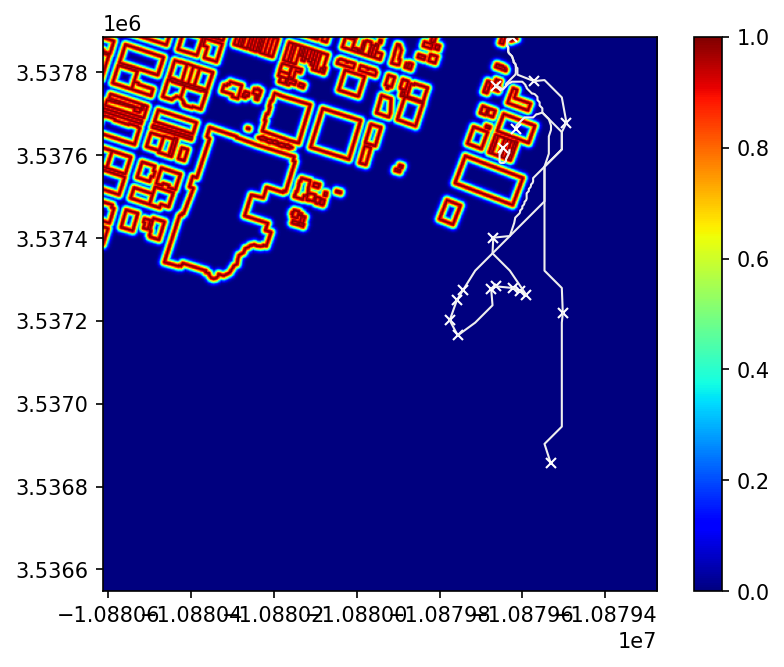

In [13]:
plt.figure(dpi=150)
plt.imshow(display, cmap='jet', extent=field.get_extent())

for i in range(n):
    if routes_xy[i] is None:
        continue 
    route_path = np.array(routes_xy[i])
    plt.plot(route_path[:, 0], route_path[:, 1], color="#eee", alpha=1.0, linewidth=1.0)
    plt.plot(route_path[-1, 0], route_path[-1, 1], 'wx', markersize=5.0)
plt.colorbar()
plt.clim(0.0,1.0)
plt.show()

In [ ]:
# Project routes to longitude and latitude
routes = [larp.project_points(route, from_crs=to_crs, to_crs=from_crs_requests).tolist() if route is not None else None for route in routes_xy]

idx = 0
for i in range(len(requestsF['routes'])):
    for j in range(len(requestsF['routes'][i])):
        requestsF['routes'][i][j]["route"] = routes[idx]
        idx += 1

requestsF['boundingbox'] = larp.project_points(requestsF['boundingbox'], from_crs=to_crs, to_crs=from_crs_requests).tolist()

# Save routes to file
with open('requested_routes.json', 'w') as f:
    json.dump(requestsF, f)